In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from BayesianExperimentalDesign import BED
from compute_distance import wasserstein_distance_normal,  kl_divergence_gaussian_params
from multiprocessing import freeze_support
from IPython.display import display, clear_output
%matplotlib inline
np.random.seed(41)

In [2]:
# Monte Carlo sampling parameters
N = 3000 # Outer samples
M = 3000 # Inner samples
num_iter = 11

num_dusts = 2
num_airports = 50
num_engines = 32

x_real = np.random.multivariate_normal(np.array([4.5,5.5]), np.array([[0.8,0.02],[0.02,0.8]]), size=num_airports)
x_real = np.abs(x_real)

sigma_real = 0.001
x_real_flat = x_real.reshape(num_dusts*num_airports)
# Variance
sigma = np.sqrt(0.25)

Acon = np.zeros(num_airports)
Acon[0] = 1
# Frequency matrix N_E * N_A
for i in range(num_engines):
    B = np.zeros(num_airports)
    for j in range((i+1)//1+1):
        B[j] = 1/((i+1)//1+1)
    Acon = np.vstack((Acon, B))

Acon = np.load('engine_airport_frequency_5.npy')

Acon = np.array([np.random.permutation(row) for row in Acon])

Acon = Acon / Acon.sum(axis=1, keepdims=True)

mean = (Acon @ x_real)
measure_noise = np.full_like(mean, 0)
for i in range(500):
    measure_noise  += np.random.normal(loc=np.full_like(mean, 0), scale=sigma_real)
measure = mean + measure_noise



BEDmodel_optimal = BED(Acon, num_dusts, sigma)
BEDmodel_random = BED(Acon, num_dusts, sigma)



num_chosen = 1
np.random.seed(2)
prior_sigma = 4
prior_mu = 5
print(x_real)

[[4.60786288 5.73881805]
 [4.91737112 4.76179673]
 [4.78644321 4.48725853]
 [4.10513832 6.09166292]
 [5.87719141 5.69313107]
 [5.47498661 5.25452638]
 [5.01449775 5.97239236]
 [4.44790694 6.87479827]
 [3.97279819 6.80809867]
 [3.10261963 4.98581876]
 [6.54596867 5.83406013]
 [5.65766949 4.76507295]
 [4.86981184 3.59336126]
 [4.60630166 5.0487178 ]
 [4.6488021  3.92418021]
 [3.70987235 4.98974978]
 [4.4995877  6.32584048]
 [4.23122074 4.11297635]
 [6.18260161 4.54519113]
 [5.62498097 5.42296423]
 [4.35251637 5.48804369]
 [5.22690837 5.33567175]
 [3.86520196 4.93846269]
 [2.93226836 5.00629154]
 [5.72933857 5.53233692]
 [4.80099783 4.62386247]
 [4.15589516 5.64060145]
 [3.95878293 5.48115147]
 [5.86078957 5.07686472]
 [5.93230981 6.64074386]
 [4.56185132 3.12796245]
 [4.7849304  3.46336561]
 [5.6070912  5.97313677]
 [4.18668553 4.01125569]
 [3.23181422 5.64955391]
 [3.72267126 4.78414014]
 [3.77858811 5.5670808 ]
 [3.8955899  4.96759677]
 [6.47964397 3.94237882]
 [5.29145513 6.22295247]


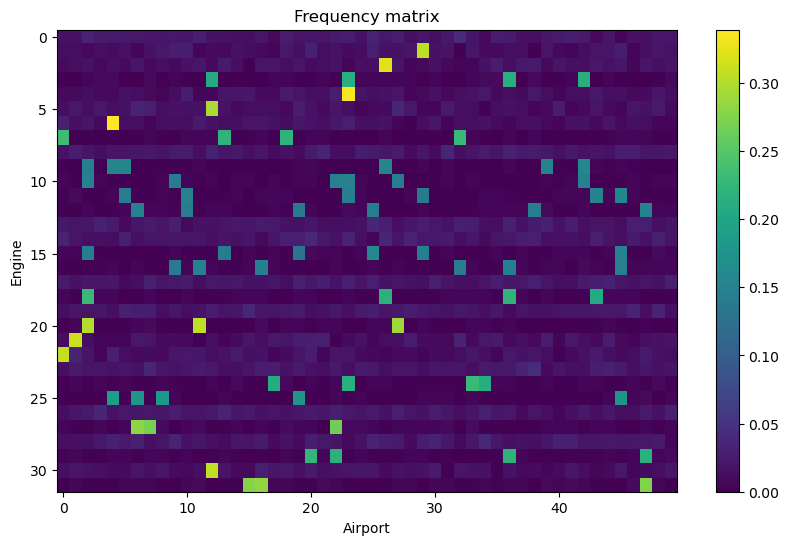

In [27]:
plt.figure(figsize=(10, 6))
plt.imshow(Acon, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Frequency matrix")
plt.xlabel("Airport")
plt.ylabel("Engine")
plt.savefig('frequency_matrix_1.png', dpi=600, bbox_inches='tight')
plt.show()

In [4]:
def run_random_trials(
    model,
    x_real,
    measure_all,
    prior_mu,
    prior_sigma,
    random_times=100
):
    """
    Runs repeated random‐design trials, but *uses* your passed‐in measurements
    instead of simulating them.  Ensures that at the final step (all engines)
    you slice *exactly* the same y‐vector in the *same* order that the solver
    expects, so the KL is identical every time.
    """
    A          = model.A
    N_e        = A.shape[0]
    nd         = model.num_dusts
    na         = model.num_airports
    D          = na * nd

    # reshape measure_all → (N_e, nd)
    m = np.asarray(measure_all)
    if m.ndim == 1:
        m = m.reshape(N_e, nd)
    elif m.shape != (N_e, nd):
        raise ValueError(f"measure_all must be (N_e, nd), got {m.shape}")

    ks          = [1,2,4,8]
    total_runs  = sum(N_e//k for k in ks)
    lwd  = np.zeros((random_times, total_runs))
    lkld = np.zeros((random_times, total_runs))

    # flatten x_real in Fortran-order to match do_experiment_normal
    x_flat = x_real.ravel(order="F")

    for r in range(random_times):
        idx = 0
        for k in ks:
            perm      = np.random.permutation(N_e)
            n_batches = N_e // k
            batches   = perm[:n_batches*k].reshape(n_batches, k)

            measured_ids = []
            for batch in batches:
                # 1) accumulate the engine‐IDs you’ve “measured” so far
                measured_ids.extend(batch.tolist())

                # 2) build the design matrix
                design_matrix = A[measured_ids, :]  # (len(measured_ids), na)

                # 3) slice the *same* measurement rows and flatten in F-order
                y_sub = m[measured_ids, :]          # (len(measured_ids), nd)
                measure = y_sub.ravel(order="F")    # length = len*nd

                # 4) do the analytic inference
                mu_post, cov_post = model.do_experiment_normal(
                    optimal_design=measured_ids,
                    measure       =measure,
                    design_matrix =design_matrix
                )

                # 5) record distances
                lwd [r, idx] = wasserstein_distance_normal(x_flat,
                                                           mu_post,
                                                           cov_post)
                lkld[r, idx] = kl_divergence_gaussian_params(
                    mu_post,
                    cov_post,
                    prior_mu  * np.ones(D),
                    (prior_sigma**2) * np.eye(D)
                )
                idx += 1

    return lwd, lkld

In [5]:
def evaluate_dynamic_designs(
    model,
    pos_seqs,
    x_real,
    measure_all,
    prior_mu,
    prior_sigma
):
    """
    Like before, but uses your passed-in measurements instead of simulating them.

    Args:
      model        : BEDmodel with .A, .num_airports, .num_dusts and method
                     do_experiment_normal(optimal_design, measure, design_matrix)
      pos_seqs     : list of 1D-or-2D arrays; each row is positions in current
                     pool to pick (removed thereafter)
      x_real       : array (na, nd), only for W₂
      measure_all  : array, shape (N_e, nd) or flat length N_e*nd: your actual data
      prior_mu     : scalar prior mean
      prior_sigma  : scalar prior std

    Returns:
      wd  : array (total_steps,) of Wasserstein-2 distances
      kld : array (total_steps,) of KL divergences
    """
    A = model.A
    N_e = A.shape[0]
    nd = model.num_dusts
    na = model.num_airports
    D  = na * nd

    # normalize/reshape measure_all → (N_e, nd)
    m = np.asarray(measure_all)
    if m.ndim == 1:
        m = m.reshape(N_e, nd)
    elif m.shape != (N_e, nd):
        raise ValueError(f"measure_all must be (N_e, nd), got {m.shape}")

    # prepare output
    total_steps = sum(seq.shape[0] for seq in pos_seqs)
    wd  = np.zeros(total_steps)
    kld = np.zeros(total_steps)

    # flatten true x in F-order
    x_flat = x_real.ravel(order="F")
    idx = 0

    for pos_seq in pos_seqs:
        remaining    = list(range(N_e))
        measured_ids = []

        for row in pos_seq.reshape(pos_seq.shape[0], -1):
            # map positions → actual engine IDs
            actual_ids = [remaining[p] for p in row]
            measured_ids.extend(actual_ids)
            # remove them
            for p in sorted(row, reverse=True):
                remaining.pop(p)

            # build cumulative design
            design_matrix = A[measured_ids, :]        # (len, na)

            # slice your real measurements
            y_sub   = m[measured_ids, :]              # (len, nd)
            measure = y_sub.ravel(order="F")          # length len*nd

            # infer analytically
            mu_post, cov_post = model.do_experiment_normal(
                optimal_design=measured_ids,
                measure       =measure,
                design_matrix =design_matrix
            )

            # record
            wd[idx]  = wasserstein_distance_normal(x_flat, mu_post, cov_post)
            kld[idx] = kl_divergence_gaussian_params(
                mu_post,
                cov_post,
                prior_mu  * np.ones(D),
                (prior_sigma**2) * np.eye(D)
            )
            idx += 1

    return wd, kld


In [6]:
# 2) Run the batched random‐design trials
lwd, lkld = run_random_trials(
    model         = BEDmodel_random,
    x_real        = x_real,
    measure_all    = measure,
    prior_mu      = prior_mu,
    prior_sigma   = prior_sigma,
    random_times  = 1000              # number of repetitions
)
final_kls = lkld[:, -1]  # last column = after all 16 engines
print("std(final KL) =", final_kls.std())

std(final KL) = 9.657240374912955e-15


In [7]:
Arr = np.array([8,4,11,11,11,2,1,8,2,0,0,3,2,2,0,0])[:, None]
opt_designs_all = [
    Arr,
    np.array([[4,8],[11,12],[2,11],[1,9],[0,2],[0,4],[2,3],[0,1]]),
    np.array([[4, 8,13,14],[1,2,10,11],[0,1,2,6],[0,1,2,3]])
]

wd, kld = evaluate_dynamic_designs(
    model        = BEDmodel_optimal,
    pos_seqs     = opt_designs_all,
    x_real       = x_real,
    measure_all    =  measure,
    prior_mu     = prior_mu,
    prior_sigma  = prior_sigma
)

In [8]:
def evaluate_optimal_designs(
    model,
    nums_chosen,
    x_real,
    measure_all,
    prior_mu,
    prior_sigma
):
    """
    Like before, but uses your passed-in measurements instead of simulating them.

    Args:
      model        : BEDmodel with .A, .num_airports, .num_dusts and method
                     do_experiment_normal(optimal_design, measure, design_matrix)
      pos_seqs     : list of 1D-or-2D arrays; each row is positions in current
                     pool to pick (removed thereafter)
      x_real       : array (na, nd), only for W₂
      measure_all  : array, shape (N_e, nd) or flat length N_e*nd: your actual data
      prior_mu     : scalar prior mean
      prior_sigma  : scalar prior std

    Returns:
      wd  : array (total_steps,) of Wasserstein-2 distances
      kld : array (total_steps,) of KL divergences
    """
    A = model.A
    N_e = A.shape[0]
    nd = model.num_dusts
    na = model.num_airports
    D  = na * nd

    # normalize/reshape measure_all → (N_e, nd)
    m = np.asarray(measure_all)
    if m.ndim == 1:
        m = m.reshape(N_e, nd)
    elif m.shape != (N_e, nd):
        raise ValueError(f"measure_all must be (N_e, nd), got {m.shape}")

    # prepare output
    total_steps = sum(N_e//num_chosen for num_chosen in nums_chosen)
    wd  = np.zeros(total_steps)
    kld = np.zeros(total_steps)

    # flatten true x in F-order
    x_flat = x_real.ravel(order="F")
    idx = 0

    for num_chosen in nums_chosen:
        remaining    = list(range(N_e))
        measured_ids = []

        for steps in range(N_e//num_chosen):
            # map positions → actual engine IDs
            if steps == 0: 
                optd, eigs = model.normal_design(A[remaining], num_chosen, prior_sigma)
            else:
                optd, eigs = model.normal_design(A[remaining], num_chosen, cov_post)

            if steps == 2 and num_chosen == 1:
                print(eigs)
            actual_ids = [remaining[p] for p in optd]
            
            measured_ids.extend(actual_ids)
            # remove them
            
            for p in sorted(optd, reverse=True):
                remaining.pop(p)

            # build cumulative design
            design_matrix = A[measured_ids, :]        # (len, na)

            # slice your real measurements
            y_sub   = m[measured_ids, :]              # (len, nd)
            measure = y_sub.ravel(order="F")          # length len*nd

            # infer analytically
            mu_post, cov_post = model.do_experiment_normal(
                optimal_design=measured_ids,
                measure       =measure,
                design_matrix =design_matrix
            )

            # record
            wd[idx]  = wasserstein_distance_normal(x_flat, mu_post, cov_post)
            kld[idx] = kl_divergence_gaussian_params(
                mu_post,
                cov_post,
                prior_mu  * np.ones(D),
                (prior_sigma**2) * np.eye(D)
            )
            idx += 1

    return wd, kld


In [9]:
wd, kld = evaluate_optimal_designs(
    model        = BEDmodel_optimal,
    nums_chosen     = [1,2,4,8],
    x_real       = x_real,
    measure_all    =  measure,
    prior_mu     = prior_mu,
    prior_sigma  = prior_sigma
)

Computing EIG for each design: 100%|██████████| 32/32 [00:00<00:00, 3044.87it/s]


Optimal engine subset for measurement: (20,)


Computing EIG for each design: 100%|██████████| 31/31 [00:00<00:00, 2818.33it/s]


Optimal engine subset for measurement: (30,)


Computing EIG for each design: 100%|██████████| 30/30 [00:00<00:00, 3333.66it/s]


Optimal engine subset for measurement: (26,)
[0.8318368276356694, 2.038330336485643, 1.9704886940571669, 2.4923590507304993, 2.0299536226097246, 1.9977572211331847, 2.1947998723705666, 2.5629997231874313, 0.8335627572294584, 2.253400922971707, 2.2089099590523062, 2.1929831547585366, 2.184042970787573, 0.8322393620466926, 0.8358377752586819, 2.1922577293187544, 2.1853500838753916, 0.8181684873240727, 2.548100435940654, 0.8174766453755069, 1.9392805065027687, 2.051469181449704, 0.8259902286414444, 2.4797960252934104, 2.4244416353912186, 0.8224129219278495, 2.677171104101177, 0.8567279919451778, 2.59425914860887, 2.0415117675622128]


Computing EIG for each design: 100%|██████████| 29/29 [00:00<00:00, 3222.29it/s]


Optimal engine subset for measurement: (7,)


Computing EIG for each design: 100%|██████████| 28/28 [00:00<00:00, 3500.05it/s]


Optimal engine subset for measurement: (26,)


Computing EIG for each design: 100%|██████████| 27/27 [00:00<00:00, 3374.94it/s]


Optimal engine subset for measurement: (22,)


Computing EIG for each design: 100%|██████████| 26/26 [00:00<00:00, 3714.55it/s]


Optimal engine subset for measurement: (22,)


Computing EIG for each design: 100%|██████████| 25/25 [00:00<00:00, 3125.04it/s]


Optimal engine subset for measurement: (3,)


Computing EIG for each design: 100%|██████████| 24/24 [00:00<00:00, 2999.32it/s]


Optimal engine subset for measurement: (16,)


Computing EIG for each design: 100%|██████████| 23/23 [00:00<00:00, 3833.61it/s]


Optimal engine subset for measurement: (7,)


Computing EIG for each design: 100%|██████████| 22/22 [00:00<00:00, 3380.40it/s]


Optimal engine subset for measurement: (8,)


Computing EIG for each design: 100%|██████████| 21/21 [00:00<00:00, 3500.53it/s]


Optimal engine subset for measurement: (5,)


Computing EIG for each design: 100%|██████████| 20/20 [00:00<00:00, 3333.71it/s]


Optimal engine subset for measurement: (7,)


Computing EIG for each design: 100%|██████████| 19/19 [00:00<00:00, 3166.77it/s]


Optimal engine subset for measurement: (9,)


Computing EIG for each design: 100%|██████████| 18/18 [00:00<00:00, 3600.09it/s]


Optimal engine subset for measurement: (1,)


Computing EIG for each design: 100%|██████████| 17/17 [00:00<00:00, 3399.92it/s]


Optimal engine subset for measurement: (12,)


Computing EIG for each design: 100%|██████████| 16/16 [00:00<00:00, 3200.23it/s]


Optimal engine subset for measurement: (2,)


Computing EIG for each design: 100%|██████████| 15/15 [00:00<00:00, 2999.65it/s]


Optimal engine subset for measurement: (14,)


Computing EIG for each design: 100%|██████████| 14/14 [00:00<00:00, 3500.05it/s]


Optimal engine subset for measurement: (1,)


Computing EIG for each design: 100%|██████████| 13/13 [00:00<00:00, 3250.24it/s]


Optimal engine subset for measurement: (3,)


Computing EIG for each design: 100%|██████████| 12/12 [00:00<00:00, 4000.29it/s]


Optimal engine subset for measurement: (1,)


Computing EIG for each design: 100%|██████████| 11/11 [00:00<00:00, 3666.93it/s]


Optimal engine subset for measurement: (4,)


Computing EIG for each design: 100%|██████████| 10/10 [00:00<00:00, 3334.10it/s]


Optimal engine subset for measurement: (6,)


Computing EIG for each design: 100%|██████████| 9/9 [00:00<00:00, 4500.86it/s]


Optimal engine subset for measurement: (3,)


Computing EIG for each design: 100%|██████████| 8/8 [00:00<00:00, 4001.24it/s]


Optimal engine subset for measurement: (4,)


Computing EIG for each design: 100%|██████████| 7/7 [00:00<00:00, 3500.67it/s]


Optimal engine subset for measurement: (4,)


Computing EIG for each design: 100%|██████████| 6/6 [00:00<00:00, 2999.50it/s]


Optimal engine subset for measurement: (5,)


Computing EIG for each design: 100%|██████████| 5/5 [00:00<00:00, 5003.94it/s]


Optimal engine subset for measurement: (3,)


Computing EIG for each design: 100%|██████████| 4/4 [00:00<00:00, 4000.29it/s]


Optimal engine subset for measurement: (0,)


Computing EIG for each design: 100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


Optimal engine subset for measurement: (2,)


Computing EIG for each design: 100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


Optimal engine subset for measurement: (0,)


Computing EIG for each design: 100%|██████████| 1/1 [00:00<?, ?it/s]


Optimal engine subset for measurement: (0,)


Computing EIG for each design: 100%|██████████| 496/496 [00:00<00:00, 3456.17it/s]


Optimal engine subset for measurement: (20, 31)


Computing EIG for each design: 100%|██████████| 435/435 [00:00<00:00, 3579.93it/s]


Optimal engine subset for measurement: (7, 26)


Computing EIG for each design: 100%|██████████| 378/378 [00:00<00:00, 3582.51it/s]


Optimal engine subset for measurement: (17, 26)


Computing EIG for each design: 100%|██████████| 325/325 [00:00<00:00, 3756.93it/s]


Optimal engine subset for measurement: (21, 22)


Computing EIG for each design: 100%|██████████| 276/276 [00:00<00:00, 3704.18it/s]


Optimal engine subset for measurement: (3, 14)


Computing EIG for each design: 100%|██████████| 231/231 [00:00<00:00, 3637.28it/s]


Optimal engine subset for measurement: (7, 9)


Computing EIG for each design: 100%|██████████| 190/190 [00:00<00:00, 3584.94it/s]


Optimal engine subset for measurement: (5, 8)


Computing EIG for each design: 100%|██████████| 153/153 [00:00<00:00, 3599.23it/s]


Optimal engine subset for measurement: (1, 13)


Computing EIG for each design: 100%|██████████| 120/120 [00:00<00:00, 3750.05it/s]


Optimal engine subset for measurement: (2, 15)


Computing EIG for each design: 100%|██████████| 91/91 [00:00<00:00, 3500.09it/s]


Optimal engine subset for measurement: (1, 4)


Computing EIG for each design: 100%|██████████| 66/66 [00:00<00:00, 3666.50it/s]


Optimal engine subset for measurement: (1, 5)


Computing EIG for each design: 100%|██████████| 45/45 [00:00<00:00, 3597.52it/s]


Optimal engine subset for measurement: (3, 6)


Computing EIG for each design: 100%|██████████| 28/28 [00:00<00:00, 3500.15it/s]


Optimal engine subset for measurement: (5, 7)


Computing EIG for each design: 100%|██████████| 15/15 [00:00<00:00, 3750.50it/s]


Optimal engine subset for measurement: (3, 4)


Computing EIG for each design: 100%|██████████| 6/6 [00:00<00:00, 2999.86it/s]


Optimal engine subset for measurement: (0, 1)


Computing EIG for each design: 100%|██████████| 1/1 [00:00<?, ?it/s]


Optimal engine subset for measurement: (0, 1)


Computing EIG for each design: 100%|██████████| 35960/35960 [00:09<00:00, 3617.08it/s]


Optimal engine subset for measurement: (7, 20, 27, 31)


Computing EIG for each design: 100%|██████████| 20475/20475 [00:05<00:00, 3622.09it/s]


Optimal engine subset for measurement: (17, 22, 23, 26)


Computing EIG for each design: 100%|██████████| 10626/10626 [00:02<00:00, 3770.94it/s]


Optimal engine subset for measurement: (3, 8, 10, 11)


Computing EIG for each design: 100%|██████████| 4845/4845 [00:01<00:00, 3819.10it/s]


Optimal engine subset for measurement: (5, 7, 10, 19)


Computing EIG for each design: 100%|██████████| 1820/1820 [00:00<00:00, 3855.64it/s]


Optimal engine subset for measurement: (1, 3, 8, 12)


Computing EIG for each design: 100%|██████████| 495/495 [00:00<00:00, 3943.96it/s]


Optimal engine subset for measurement: (1, 2, 6, 8)


Computing EIG for each design: 100%|██████████| 70/70 [00:00<00:00, 3888.86it/s]


Optimal engine subset for measurement: (0, 3, 5, 7)


Computing EIG for each design: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]

Optimal engine subset for measurement: (0, 1, 2, 3)



Computing EIG for each design: 100%|██████████| 10518300/10518300 [48:56<00:00, 3581.48it/s]


Optimal engine subset for measurement: (3, 7, 18, 20, 24, 25, 27, 31)


Computing EIG for each design: 100%|██████████| 735471/735471 [03:20<00:00, 3665.46it/s]


Optimal engine subset for measurement: (5, 7, 8, 9, 10, 13, 22, 23)


Computing EIG for each design: 100%|██████████| 12870/12870 [00:03<00:00, 3459.10it/s]


Optimal engine subset for measurement: (1, 2, 3, 4, 8, 11, 12, 13)


Computing EIG for each design: 100%|██████████| 1/1 [00:00<?, ?it/s]

Optimal engine subset for measurement: (0, 1, 2, 3, 4, 5, 6, 7)


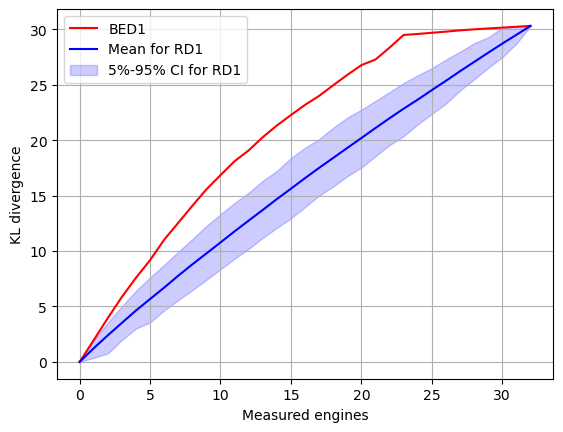

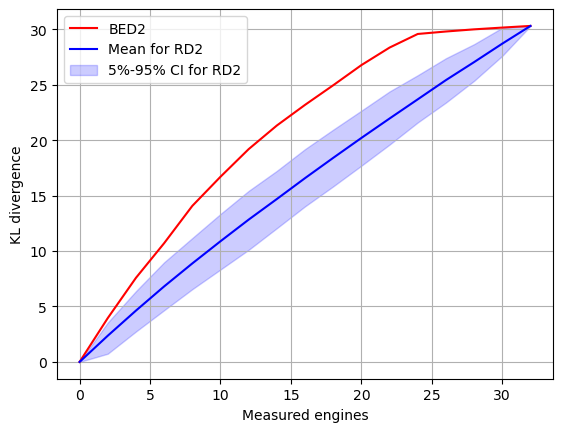

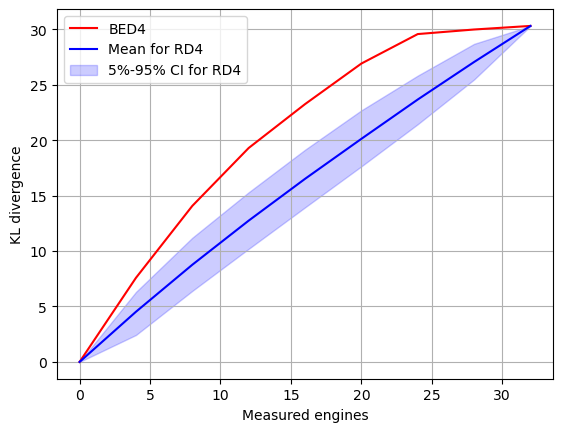

[ 8.78928076 16.5548832  23.73209814 30.30872866]


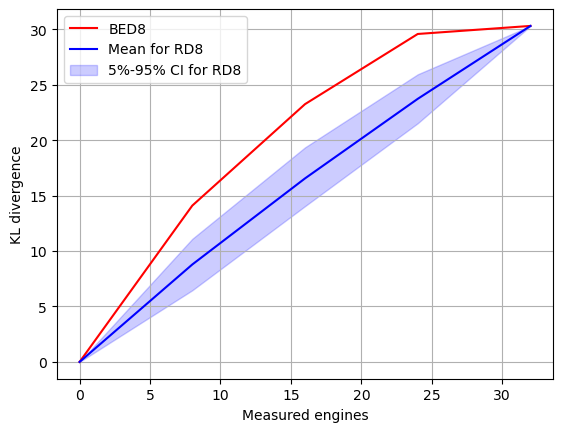

In [10]:
mean = np.mean(lkld, axis = 0)
lower = np.percentile(lkld, 5, axis=0)
upper = np.percentile(lkld, 95, axis=0)
plt.plot(np.arange(0,33), np.insert(kld[:32],0,0),'r-', label='BED1')
plt.plot(np.arange(0,33), np.insert(mean[:32],0,0), 'b-', label='Mean for RD1')
plt.fill_between(np.arange(0,33), np.insert(lower[:32],0,0), np.insert(upper[:32],0,0), color='blue', alpha=0.2, label='5%-95% CI for RD1')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('KL divergence')
plt.savefig('KLD_A50E32BED1.png', dpi=600, bbox_inches='tight')
plt.show()
plt.plot(np.arange(0,33,2), np.insert(kld[32:48],0,0),'r-', label='BED2')
plt.plot(np.arange(0,33,2), np.insert(mean[32:48],0,0), 'b-', label='Mean for RD2')
plt.fill_between(np.arange(0,33,2), np.insert(lower[32:48],0,0), np.insert(upper[32:48],0,0), color='blue', alpha=0.2, label='5%-95% CI for RD2')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('KL divergence')
plt.savefig('KLD_A50E32BED2.png', dpi=600, bbox_inches='tight')
plt.show()
plt.plot(np.arange(0,33,4), np.insert(kld[48:56],0,0),'r-', label='BED4')
plt.plot(np.arange(0,33,4), np.insert(mean[48:56],0,0), 'b-', label='Mean for RD4')
plt.fill_between(np.arange(0,33,4), np.insert(lower[48:56],0,0), np.insert(upper[48:56],0,0), color='blue', alpha=0.2, label='5%-95% CI for RD4')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('KL divergence')
plt.savefig('KLD_A50E32BED4.png', dpi=600, bbox_inches='tight')
plt.show()
print(mean[56:60])
plt.plot(np.arange(0,33,8), np.insert(kld[56:60],0,0),'r-', label='BED8')
plt.plot(np.arange(0,33,8), np.insert(mean[56:60],0,0), 'b-', label='Mean for RD8')
plt.fill_between(np.arange(0,33,8), np.insert(lower[56:60],0,0), np.insert(upper[56:60],0,0), color='blue', alpha=0.2, label='5%-95% CI for RD8')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('KL divergence')
plt.savefig('KLD_A50E32BED8.png', dpi=600, bbox_inches='tight')
plt.show()

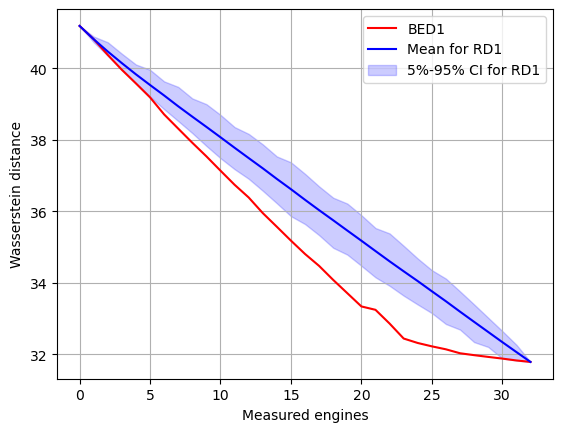

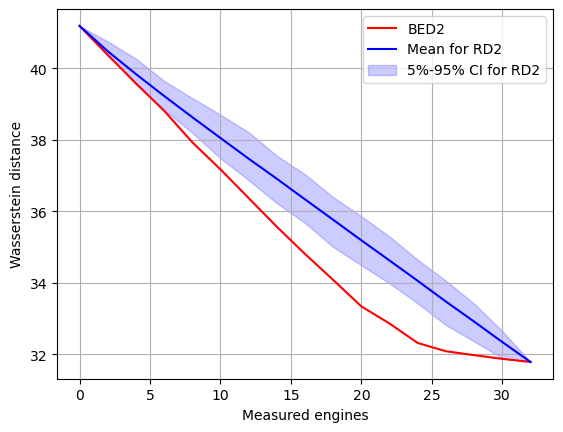

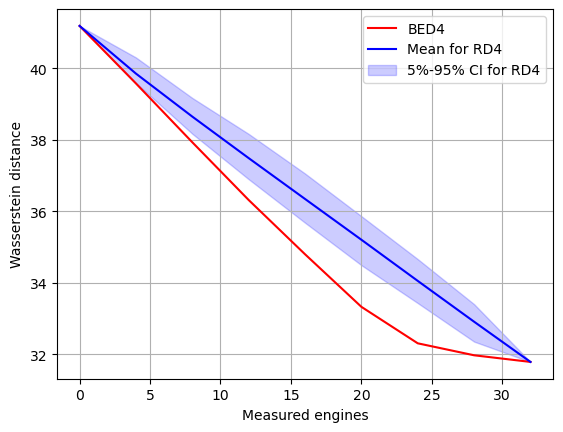

[38.65558159 36.33791988 34.03196167 31.78533127]


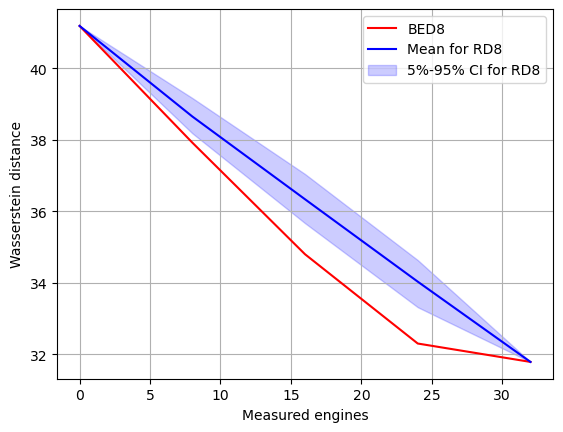

In [11]:
D = 100
mean = np.mean(lwd, axis = 0)
lower = np.percentile(lwd, 5, axis=0)
upper = np.percentile(lwd, 95, axis=0)
plt.plot(np.arange(0,33), np.insert(wd[:32],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),'r-', label='BED1')
plt.plot(np.arange(0,33), np.insert(mean[:32],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), 'b-', label='Mean for RD1')
plt.fill_between(np.arange(0,33), np.insert(lower[:32],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), np.insert(upper[:32],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), color='blue', alpha=0.2, label='5%-95% CI for RD1')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('Wasserstein distance')
plt.savefig('WD_A50E32BED1.png', dpi=600, bbox_inches='tight')
plt.show()
plt.plot(np.arange(0,33,2), np.insert(wd[32:48],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),'r-', label='BED2')
plt.plot(np.arange(0,33,2), np.insert(mean[32:48],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), 'b-', label='Mean for RD2')
plt.fill_between(np.arange(0,33,2), np.insert(lower[32:48],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), np.insert(upper[32:48],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), color='blue', alpha=0.2, label='5%-95% CI for RD2')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('Wasserstein distance')
plt.savefig('WD_A50E32BED2.png', dpi=600, bbox_inches='tight')
plt.show()
plt.plot(np.arange(0,33,4), np.insert(wd[48:56],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),'r-', label='BED4')
plt.plot(np.arange(0,33,4), np.insert(mean[48:56],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), 'b-', label='Mean for RD4')
plt.fill_between(np.arange(0,33,4), np.insert(lower[48:56],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), np.insert(upper[48:56],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), color='blue', alpha=0.2, label='5%-95% CI for RD4')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('Wasserstein distance')
plt.savefig('WD_A50E32BED4.png', dpi=600, bbox_inches='tight')
plt.show()
print(mean[56:60])
plt.plot(np.arange(0,33,8), np.insert(wd[56:60],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),'r-', label='BED8')
plt.plot(np.arange(0,33,8), np.insert(mean[56:60],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), 'b-', label='Mean for RD8')
plt.fill_between(np.arange(0,33,8), np.insert(lower[56:60],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), np.insert(upper[56:60],0,wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))), color='blue', alpha=0.2, label='5%-95% CI for RD8')
plt.grid()
plt.legend()
plt.xlabel('Measured engines')
plt.ylabel('Wasserstein distance')
plt.savefig('WD_A50E32BED8.png', dpi=600, bbox_inches='tight')
plt.show()

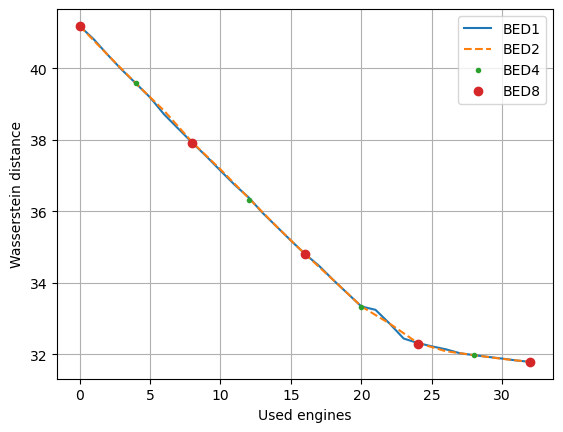

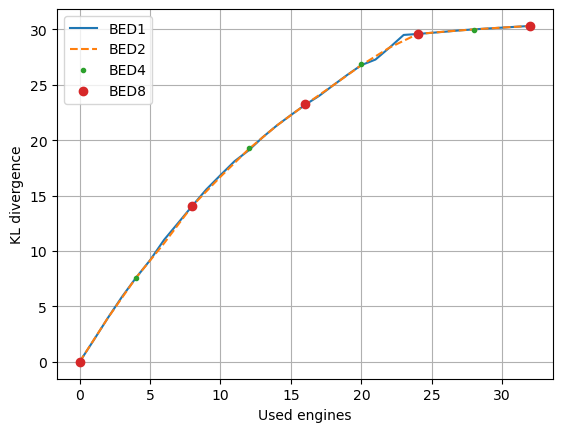

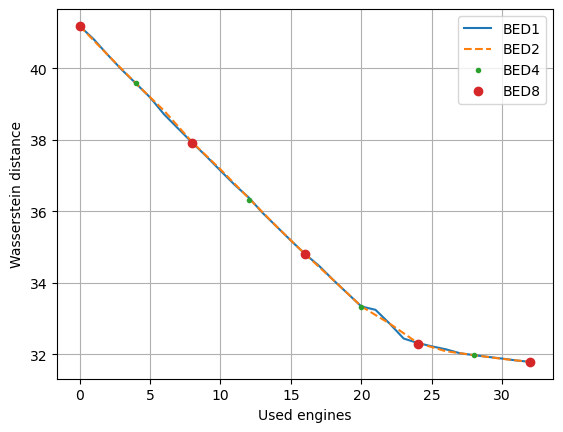

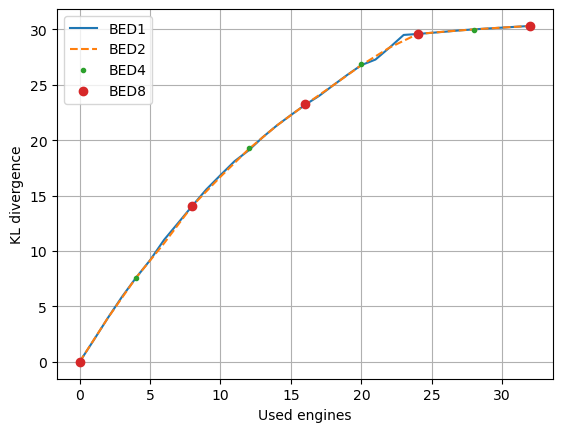

In [12]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
D = 100
# Wasserstein distance plot
ax1.plot(np.arange(0,33), np.insert(wd[:32], 0, wasserstein_distance_normal(x_real_flat,prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),
         '-', label='BED1')
ax1.plot(np.arange(0,33,2), np.insert(wd[32:48], 0, wasserstein_distance_normal(x_real_flat,prior_mu  * np.ones(D),(prior_sigma**2) * np.eye(D))),
         '--', label='BED2')
ax1.plot(np.arange(0,33,4), np.insert(wd[48:56], 0, wasserstein_distance_normal(x_real_flat, prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),
         '.', label='BED4')
ax1.plot(np.arange(0,33,8), np.insert(wd[56:60], 0, wasserstein_distance_normal(x_real_flat, prior_mu * np.ones(D),(prior_sigma**2) * np.eye(D))),
         'o', label='BED8')

ax1.set_xlabel('Used engines')
ax1.set_ylabel('Wasserstein distance')
ax1.legend()
ax1.grid(True)

# Save the first figure
fig1.savefig('wd_A50E32.png', dpi=600, bbox_inches='tight')

# KL divergence plot
ax2.plot(np.arange(0,33), np.insert(kld[:32], 0, 0), '-', label='BED1')
ax2.plot(np.arange(0,33,2), np.insert(kld[32:48], 0, 0), '--', label='BED2')
ax2.plot(np.arange(0,33,4), np.insert(kld[48:56], 0, 0), '.', label='BED4')
ax2.plot(np.arange(0,33,8), np.insert(kld[56:60], 0, 0), 'o', label='BED8')



ax2.set_xlabel('Used engines')
ax2.set_ylabel('KL divergence')
ax2.legend()
ax2.grid(True)

# Save the second figure
fig2.savefig('kld_A50E32.png', dpi=600, bbox_inches='tight')

# Display figures in Jupyter
display(fig1)
display(fig2)
